In [ ]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

reviews_df = getDF('/content/drive/MyDrive/ml projects/Toys_and_Games_5.json.gz')

In [ ]:
reviews_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1828971 entries, 0 to 1828970
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   style           object 
 7   reviewerName    object 
 8   reviewText      object 
 9   summary         object 
 10  unixReviewTime  int64  
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 169.2+ MB


<Axes: xlabel='overall', ylabel='count'>

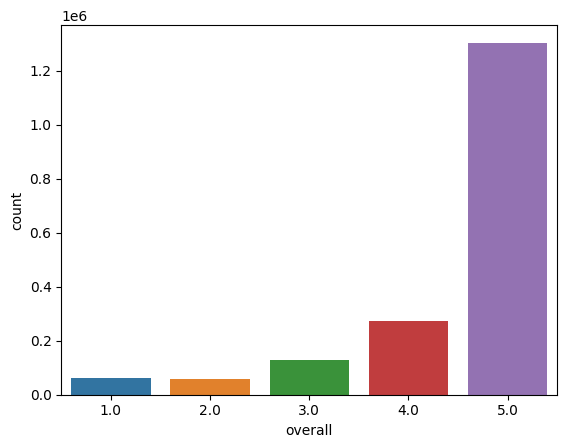

In [ ]:
sns.countplot(data = reviews_df, x='overall')


In [ ]:
len(reviews_df['asin'].value_counts(dropna=False))


78772

In [ ]:
one_10000 = reviews_df[reviews_df['overall']==1.0].sample(n=10000)
two_3000 = reviews_df[reviews_df['overall']==2.0].sample(n=3000)
three_3000 = reviews_df[reviews_df['overall']==3.0].sample(n=3000)
four_3000 = reviews_df[reviews_df['overall']==4.0].sample(n=3000)
five_10000 = reviews_df[reviews_df['overall']==5.0].sample(n=10000)

In [ ]:
undersampled_reviews = pd.concat([one_10000, two_3000, three_3000, four_3000, five_10000], axis=0)


In [ ]:
undersampled_reviews['overall'].value_counts(dropna=False)


1.0    10000
5.0    10000
2.0     3000
3.0     3000
4.0     3000
Name: overall, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

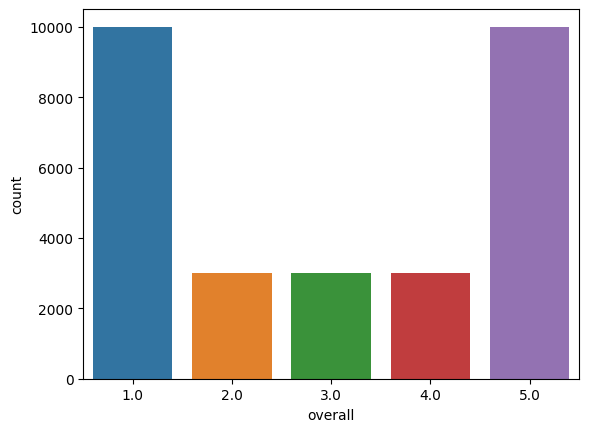

In [ ]:
sns.countplot(data=undersampled_reviews, x='overall')


In [ ]:
sample_300K_revs = reviews_df.sample(n=300000, random_state=42)


In [ ]:
undersampled_reviews.to_csv("/content/drive/MyDrive/ml projects/small_corpus.csv", index=False)


In [ ]:
sample_300K_revs.to_csv("/content/drive/MyDrive/ml projects/big_corpus.csv", index=False)


# sentiment model-sentiwordnet

In [ ]:
from nltk import sent_tokenize, pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.util import mark_negation
from string import punctuation
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
def penn_to_wn(tag):
    """
        Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [ ]:
def get_sentiment_score(text):

    """
        This method returns the sentiment score of a given text using SentiWordNet sentiment scores.
        input: text
        output: numeric (double) score, >0 means positive sentiment and <0 means negative sentiment.
    """
    total_score = 0
    #print(text)
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)

    for sentence in raw_sentences:

        sent_score = 0
        sentence = str(sentence)
        #print(sentence)
        sentence = sentence.replace("<br />"," ").translate(str.maketrans('','',punctuation)).lower()
        tokens = TreebankWordTokenizer().tokenize(text)
        tags = pos_tag(tokens)
        for word, tag in tags:
            wn_tag = penn_to_wn(tag)
            if not wn_tag:
                continue
            lemma = WordNetLemmatizer().lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sent_score += swn_synset.pos_score() - swn_synset.neg_score()

        total_score = total_score + (sent_score / len(tokens))


    return (total_score / len(raw_sentences)) * 100


In [ ]:
reviews = pd.read_csv("/content/drive/MyDrive/ml projects/small_corpus.csv")


In [ ]:
reviews.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1.0,NaN,True,"03 30, 2015",ACPIKFS5JO8N,B00IVFC6IU,NaN,TwinB79,I thought it would be nicer then it is.,let down,1427673600,NaN
1,1.0,NaN,False,"08 28, 2014",A4099DQV1BD3X,B00DU4A4JK,NaN,Kenneth Boston,parts missing .,One Star,1409184000,NaN
2,1.0,NaN,True,"08 21, 2016",AQR86YXALSC36,B007Q2KZU0,{'Color:': ' Chocolate'},Blackhawk,Total disappointment... Cute idea though... These don't hold air. Other floaters we've had in the past held up way better than these. I was so disappointed because I loved how cute they were. But my husband hated the quality so much he convinced my 9 yo they belonged in the trash! I didn't even know they threw them away... Don't waste your money.,Very Poor Quality,1471737600,NaN
3,1.0,NaN,True,"10 28, 2014",A1NE7N34YX7Q66,B000GKUAUY,"{'Size:': ' Medium', 'Color:': ' As Shown', 'Product Packaging:': ' Standard Packaging'}",Ike,"Darker than pictured. This is not a ""deluxe"" costume for sure.as it looks cheap just like other ""non-deluxe"" Jedi costumes.","as it looks cheap just like other ""non-deluxe"" Jedi costumes",1414454400,NaN
4,1.0,NaN,True,"11 12, 2015",A18EWO48Y8C5BB,B00EWYJFME,NaN,Juliane Walker,Order another set--this one costs more because of the extra coloring book and pencils--they were not included! Misleading and what an inconvenience.,Extra Book/pencils NOT incuded,1447286400,NaN


In [ ]:
reviews.dropna(subset=['reviewText'], inplace=True)


In [ ]:
reviews.shape

(28988, 12)

In [ ]:
reviews['swn_score'] = reviews['reviewText'].apply(lambda text : get_sentiment_score(text))


In [ ]:
import nltk
nltk.download('sentiwordnet')


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [ ]:
reviews[['reviewText','swn_score']].sample(20)


,reviewText,swn_score
14413,This Item came in very good conditions up to Mexico so If you plan big gifts for the girls it will be a nice option.,7.211538
28153,Pink balloons. What can I say. Good value,7.812500


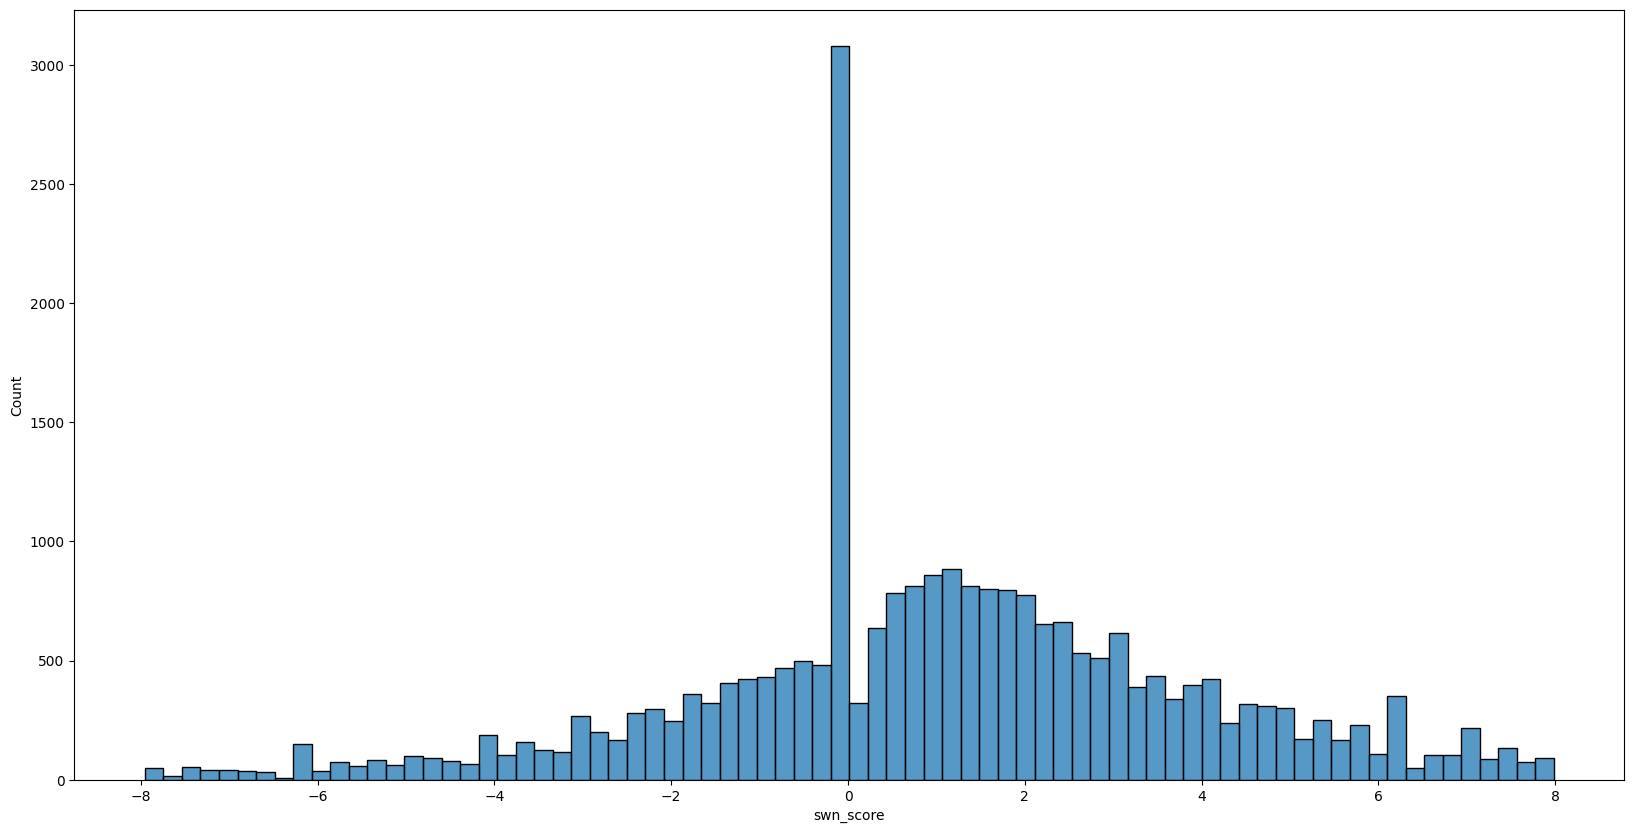

In [ ]:
fig , ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.histplot(x='swn_score', data=reviews.query("swn_score < 8 and swn_score > -8"), ax=ax)
plt.show()

In [ ]:
reviews['swn_sentiment'] = reviews['swn_score'].apply(lambda x: "positive" if x>1 else ("negative" if x<0.5 else "neutral"))


In [ ]:
reviews['swn_sentiment'].value_counts(dropna=False)


positive    15413
negative    11607
neutral      1968
Name: swn_sentiment, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

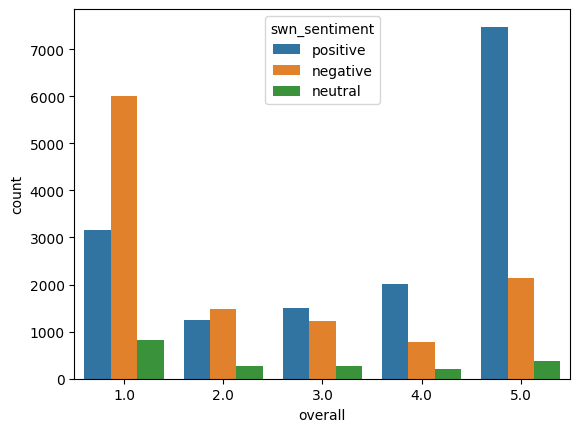

In [ ]:
sns.countplot(x='overall', hue='swn_sentiment' ,data = reviews)
